# Numerical tests for paper

In [73]:
import os
import sys
import time

import deepwave
import matplotlib.pyplot as plt
import numpy as np
import torch
from deepwave import scalar

sys.path.append("../")
sys.path.append(os.path.join(os.path.dirname(""), os.pardir, os.pardir))
import coherence_analysis.utils as f

Choose which device we wish to run on, specify the size of the model, and load it:

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
ny = 2301
nx = 751
dx = 0.5

# v = 1500 * torch.ones(ny, nx)
# v[int(ny/2):] = 2000

marmousi_offset_left = 200
marmousi_offset_right = 0
ny = min(2301 - marmousi_offset_left - marmousi_offset_right, ny)

assert (
    marmousi_offset_left + marmousi_offset_right + ny <= 2301
), "Offsets exceed the model size."
assert (
    min(marmousi_offset_left, marmousi_offset_right) == 0
), "To stay true to offsets, one side must be unrestricted i.e set to 0."

v = torch.from_file("marmousi_vp.bin", size=(ny + marmousi_offset_left) * nx)
v = v[marmousi_offset_left * nx :].reshape(ny, nx).to(device)

Make a plot of the velocity model:

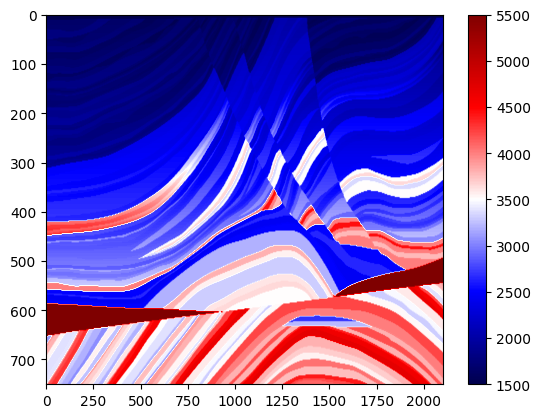

In [76]:
plt.imshow(v.cpu().numpy().T, cmap="seismic", aspect="auto")
plt.colorbar()

In [77]:
n_shots = 1

n_sources_per_shot = 2
d_source = 1500  # 20 * 4m = 80m
first_source = 10  # 10 * 4m = 40m
source_depth = 500  # 2 * 4m = 8m
# first_source = int(ny/2)
# source_depth = int(2*nx/3)

n_receivers_per_shot = 384
d_receiver = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 2  # 2 * 4m = 8m

n_receivers_per_shot = min(n_receivers_per_shot, int(nx / d_receiver))

freq = 10
nt = 750 * 10
dt = 0.004
peak_time = 20 / freq

# source_locations
source_locations = torch.zeros(
    n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device
)

source_locations[..., 1, 0] = 500
source_locations[..., 1, 1] = 700

# source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = torch.arange(n_shots) * d_source + first_source

# receiver_locations
receiver_locations = torch.zeros(
    n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device
)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    torch.arange(n_receivers_per_shot) * d_receiver + first_receiver
).repeat(n_shots, 1)

# source_amplitudes
# source_amplitudes = (
#     deepwave.wavelets.ricker(freq, nt, dt, peak_time)
#     .repeat(n_shots, n_sources_per_shot, 1)
#     .to(device)
# )

source_amplitudes = (torch.cat((deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1),
                    deepwave.wavelets.ricker(freq + 5, nt, dt, 2 + peak_time).repeat(n_shots, 1, 1)), dim=1)).to(device)

### Propagate wavefield to generate synthetic receiver data

In [78]:
out = scalar(
    v,
    dx,
    dt,
    source_amplitudes=source_amplitudes,
    source_locations=source_locations,
    receiver_locations=receiver_locations,
    accuracy=8,
    pml_freq=freq,
)

Text(0, 0.5, 'Amplitude')

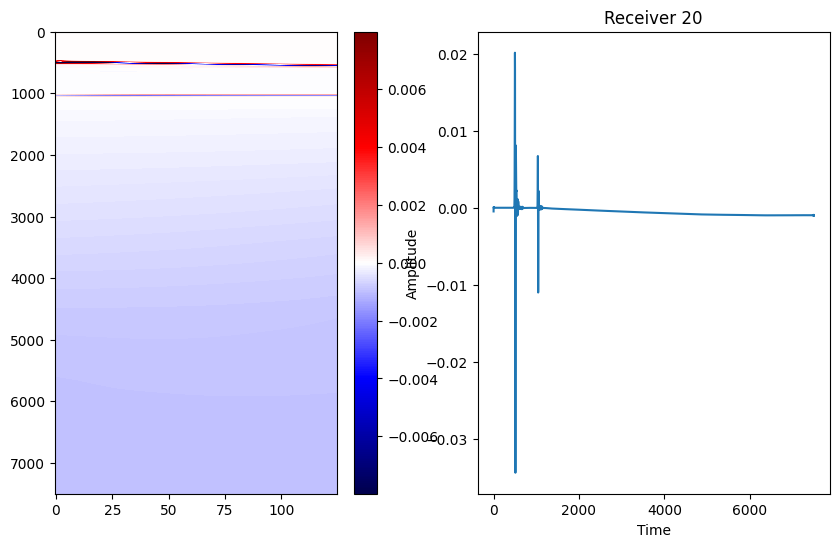

In [100]:
receiver_amplitudes = out[-1]

vmin, vmax = torch.quantile(
    receiver_amplitudes[0], torch.tensor([0.1, 0.999]).to(device)
)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(
    receiver_amplitudes.cpu()[0].T,
    aspect="auto",
    cmap="seismic",
    vmin=-vmax,
    vmax=vmax,
)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(receiver_amplitudes.cpu()[0, 19])
plt.title("Receiver 20")
plt.xlabel("Time")
plt.ylabel("Amplitude")

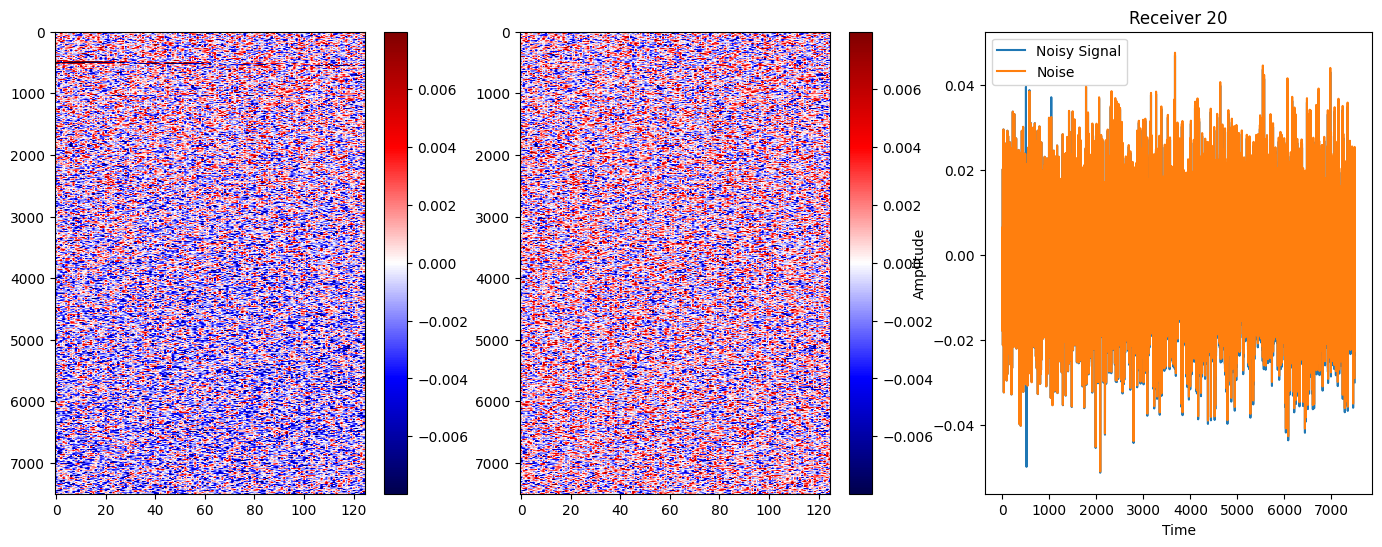

In [167]:
plt.figure(figsize=(17, 6))
coherence_data = receiver_amplitudes[0].cpu().numpy()
nr, nc = coherence_data.shape
noise = np.random.normal(scale=1, size=(nr, nc))
# normalize noise
# noise = noise / np.linalg.norm(noise)
noise = noise / np.max(np.abs(noise))
noise = noise * np.max(np.abs(coherence_data)) * 0.5
coherence_data = coherence_data + noise
# coherence_data.shape
vmin, vmax = torch.quantile(
    receiver_amplitudes[0], torch.tensor([0.1, 0.999]).to(device)
)
plt.subplot(1, 3, 1)
plt.imshow(
    coherence_data.T, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax
)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(noise.T, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.plot(coherence_data[19], label='Noisy Signal')
plt.plot(noise[19], label='Noise')
plt.title("Receiver 20")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

In [168]:
win_len = 2
overlap = 0
samples_per_sec = 1 / dt

t0 = time.time()
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    coherence_data, win_len, overlap, sample_interval=1 / samples_per_sec
)
t1 = time.time()
common_time = t1 - t0

welch_coherence_mat = np.matmul(
    norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0, 2, 1))
)
coherence = np.absolute(welch_coherence_mat) ** 2

norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    noise, win_len, overlap, sample_interval=1 / samples_per_sec
)
welch_coherence_mat_noise = np.matmul(
    norm_win_spectra_noise,
    np.conjugate(norm_win_spectra_noise.transpose(0, 2, 1)),
)
coherence_noise = np.absolute(welch_coherence_mat_noise) ** 2

In [169]:
num_frames = coherence.shape[0]

event_detection = np.empty(num_frames)
event_detection_qr = np.empty(num_frames)
event_detection_svd = np.empty(num_frames)

noise_detection = np.empty(num_frames)
noise_detection_qr = np.empty(num_frames)
noise_detection_svd = np.empty(num_frames)

t0 = time.time()
welch_coherence_mat = np.matmul(
    norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0, 2, 1))
)
coherence2 = np.absolute(welch_coherence_mat) ** 2
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(coherence2[d])
    eigenvals = np.linalg.eigvalsh(coherence2[d])
    # eigenvals = sl.eigvalsh(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    event_detection[d] = np.max(eigenvals) / np.sum(eigenvals)

    eigenvals = np.linalg.eigvalsh(coherence_noise[d])
    # eigenvals = sl.eigvalsh(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    noise_detection[d] = np.max(eigenvals) / np.sum(eigenvals)
    # eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)
t1 = time.time()
eig_time = t1 - t0 + common_time

t0 = time.time()
for d in range(num_frames):
    Q, R = np.linalg.qr(norm_win_spectra[d])
    # qr_approx2 = np.sort(np.diag(np.absolute(R@(R.getH()))))[::-1]

    RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH),0.5)
    qr_approx2 = np.diag(RRH)
    event_detection_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)

    Q, R = np.linalg.qr(norm_win_spectra_noise[d])
    # qr_approx2 = np.sort(np.diag(np.absolute(R@(R.getH()))))[::-1]

    RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH),1)
    qr_approx2 = np.diag(RRH)
    noise_detection_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)
t1 = time.time()
qr_time = t1 - t0 + common_time

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(norm_win_spectra[d], full_matrices=False)
    S = np.linalg.svd(norm_win_spectra[d], compute_uv=False, hermitian=False)
    # S= np.linalg.svdvals(norm_win_spectra[d])
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    event_detection_svd[d] = np.max(svd_approx2) / np.sum(svd_approx2)

    S = np.linalg.svd(
        norm_win_spectra_noise[d], compute_uv=False, hermitian=False
    )
    # S = np.linalg.svdvals(norm_win_spectra_noise[d])
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    noise_detection_svd[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
svd_time = t1 - t0 + common_time

print("Eigenvalue time: ", eig_time)
print("QR time: ", qr_time)
print("SVD time: ", svd_time)

Eigenvalue time:  0.9978492259979248
QR time:  0.1138145923614502
SVD time:  0.09719967842102051


C:\Users\issah\AppData\Local\Temp\ipykernel_252\2917901325.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  event_detection_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)
C:\Users\issah\AppData\Local\Temp\ipykernel_252\2917901325.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  noise_detection_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)


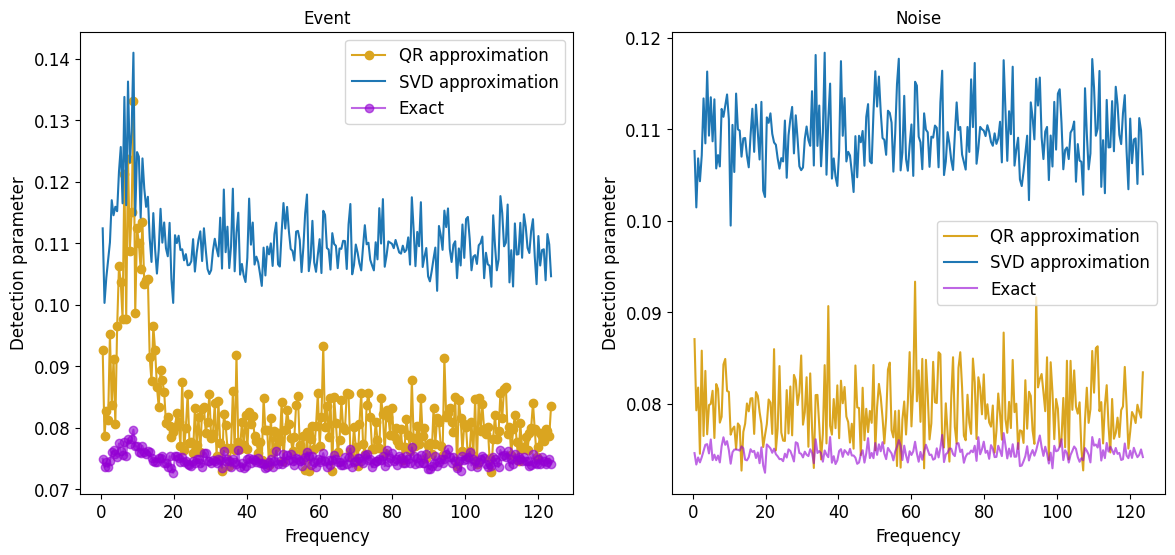

In [170]:
fsize = 12
last_freq_index = -1
f_plot = np.linspace(0, 124, num_frames)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(
    f_plot[1:last_freq_index],
    event_detection_qr[1:last_freq_index],
    "-o",
    color="goldenrod",
    label="QR approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    event_detection_svd[1:last_freq_index],
    label="SVD approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    event_detection[1:last_freq_index],
    "-o",
    color="darkviolet",
    alpha=0.6,
    label="Exact",
)

plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Event", fontsize=fsize)
plt.legend(fontsize=fsize)

plt.subplot(1, 2, 2)
plt.plot(
    f_plot[1:last_freq_index],
    noise_detection_qr[1:last_freq_index],
    color="goldenrod",
    label="QR approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    noise_detection_svd[1:last_freq_index],
    label="SVD approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    noise_detection[1:last_freq_index],
    color="darkviolet",
    alpha=0.6,
    label="Exact",
)

plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Noise", fontsize=fsize)
plt.legend(fontsize=fsize)

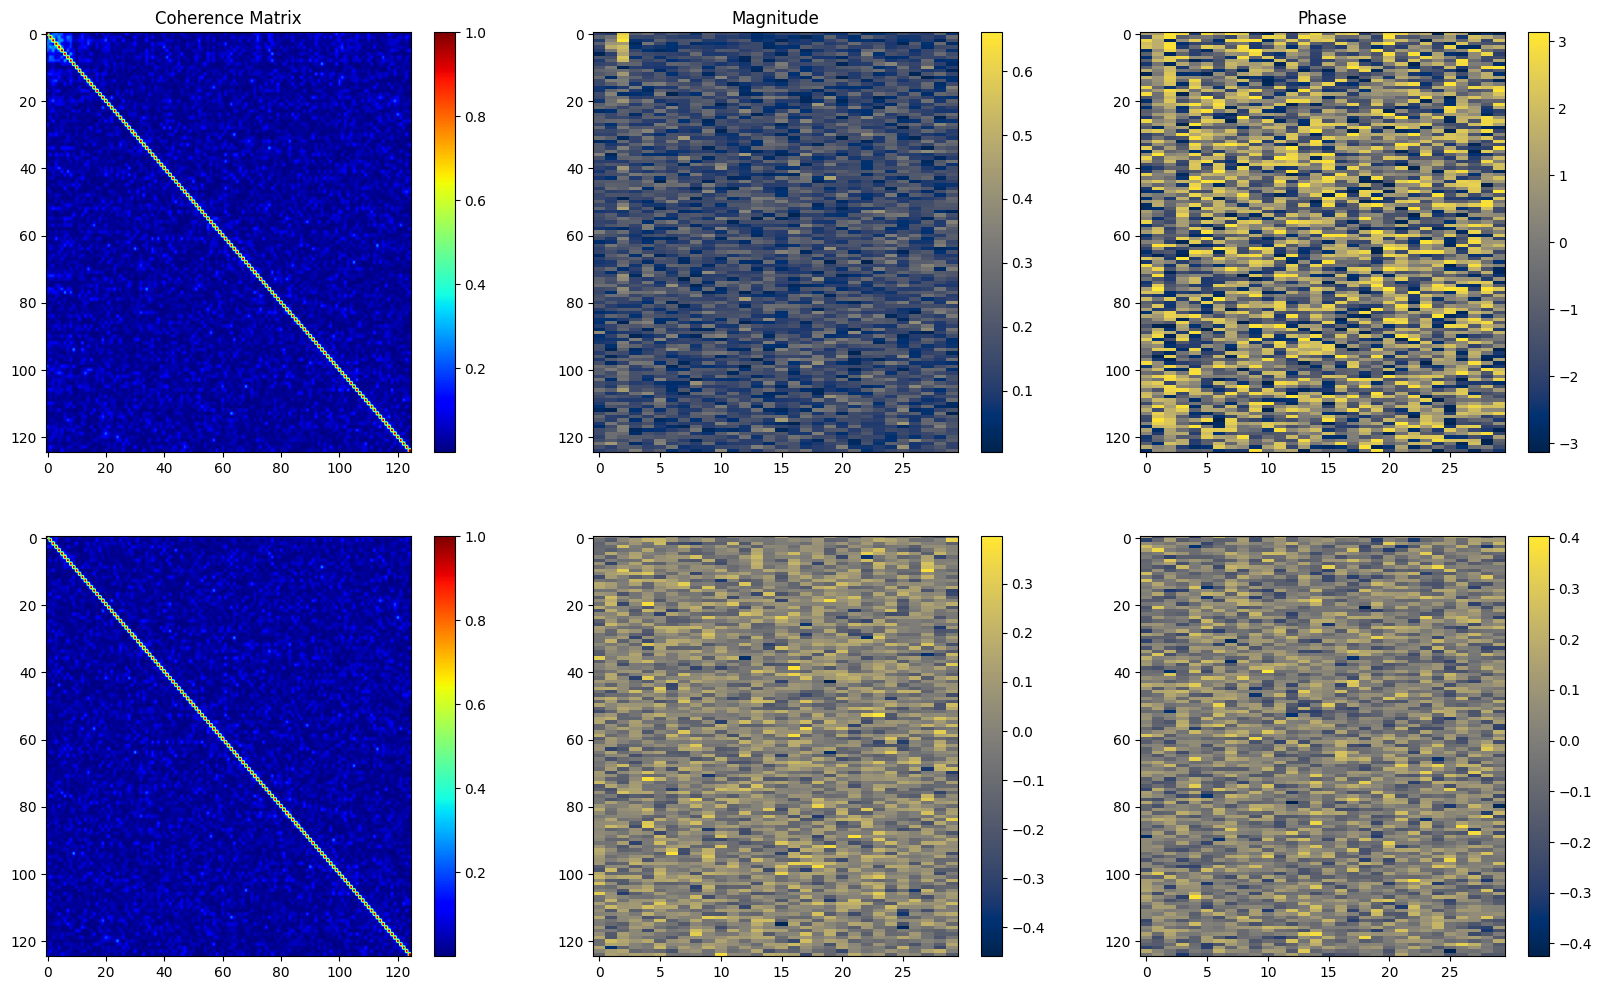

In [84]:
norm_win_spectra.shape
i = 5
# samples_per_sec
# coherence.shape
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.imshow(coherence[i], aspect="auto", cmap="jet")
plt.colorbar()
plt.title("Coherence Matrix")
plt.subplot(2, 3, 2)
# plt.imshow(norm_win_spectra[i].real, aspect='auto', cmap='cividis')
plt.imshow(np.absolute(norm_win_spectra[i]), aspect="auto", cmap="cividis")
plt.colorbar()
plt.title("Magnitude")
plt.subplot(2, 3, 3)
# plt.imshow(norm_win_spectra[i].imag, aspect='auto', cmap='cividis')
plt.imshow(np.angle(norm_win_spectra[i]), aspect="auto", cmap="cividis")
plt.colorbar()
plt.title("Phase")
plt.subplot(2, 3, 4)
plt.imshow(coherence_noise[i], aspect="auto", cmap="jet")
plt.colorbar()
plt.subplot(2, 3, 5)
plt.imshow(norm_win_spectra_noise[i].real, aspect="auto", cmap="cividis")
plt.colorbar()
plt.subplot(2, 3, 6)
plt.imshow(norm_win_spectra_noise[i].imag, aspect="auto", cmap="cividis")
plt.colorbar()

In [85]:
tick_size = 12
fsize = 14
colors = ["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"]

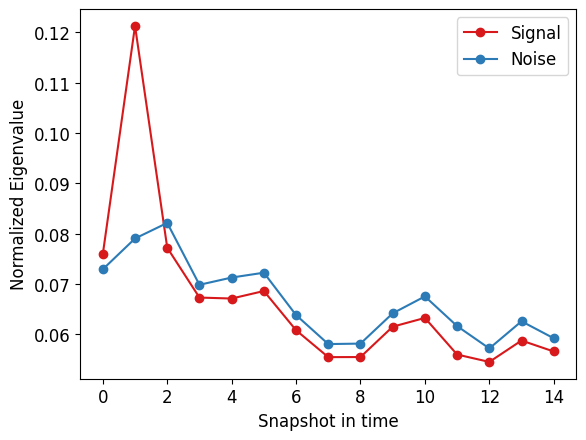

In [173]:
i = 13
Q, R = np.linalg.qr(norm_win_spectra[i])
qr_signal1 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
Q, R = np.linalg.qr(norm_win_spectra_noise[i])
qr_signal2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)

plt.plot(qr_signal1 / np.sum(qr_signal1), "-o", color=colors[4], label="Signal")
plt.plot(qr_signal2 / np.sum(qr_signal2), "-o", color=colors[0], label="Noise")
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
plt.xlabel("Snapshot in time", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.ylim([-0.02, 0.9])
plt.legend(fontsize=tick_size)

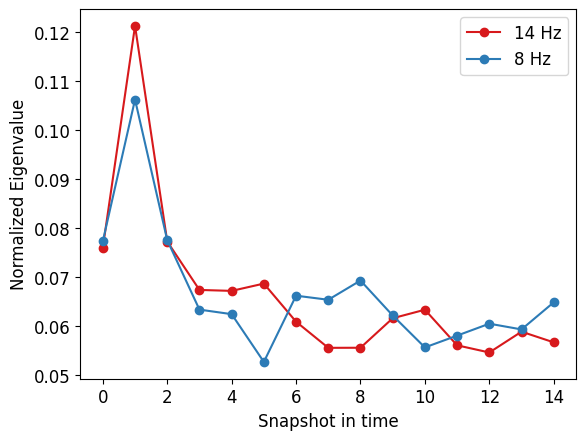

In [174]:
k = 23
l = 25
m = 27
j = 10

Q, R = np.linalg.qr(norm_win_spectra[i])
qr_signal1 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
Q, R = np.linalg.qr(norm_win_spectra[k])
qr_signal3 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
Q, R = np.linalg.qr(norm_win_spectra[l])
qr_signal4 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
Q, R = np.linalg.qr(norm_win_spectra[m])
qr_signal5 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
Q, R = np.linalg.qr(norm_win_spectra[j])
qr_signal2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)

plt.plot(qr_signal1 / np.sum(qr_signal1), "-o", color=colors[4], label="14 Hz")
# plt.plot(qr_signal5 / np.sum(qr_signal5), "-o", color=colors[3], label="11 Hz")
# plt.plot(qr_signal4 / np.sum(qr_signal4), "-o", color=colors[2], label="10 Hz")
# plt.plot(qr_signal3 / np.sum(qr_signal3), "-o", color=colors[1], label="9 Hz")
plt.plot(qr_signal2 / np.sum(qr_signal2), "-o", color=colors[0], label="8 Hz")
plt.ylabel("Normalized Eigenvalue", fontsize=fsize)
plt.xlabel("Snapshot in time", fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.ylim([-0.02, 0.9])
plt.legend(fontsize=tick_size)

## Comparison with STA/LTA method

In [171]:
def stalta_freq(data, len_lt, len_st):
    # Does stalta on data with len_lt as the length of the longtime and len_st
    # as the length of the short time
    import scipy.signal as ss
    if data.ndim == 1:
        longtime_avg = ss.correlate(
            np.absolute(data), np.ones(len_lt), mode="valid"
        )
        shorttime_avg = ss.correlate(
            np.absolute(data[(len_lt - len_st) :]),
            np.ones(len_st),
            mode="valid",
        )
        stalta = (shorttime_avg * len_lt) / (longtime_avg * len_st)
    elif data.ndim == 2:
        nch, nsamples = data.shape
        stalta = np.empty((nch, nsamples - len_lt + 1), dtype=np.float64)
        longtime_stencil = np.ones(int(len_lt))
        shorttime_stencil = np.ones(int(len_st))
        for a in range(nch):
            longtime_avg = ss.correlate(
                np.absolute(data[a]), longtime_stencil, mode="valid"
            )
            shorttime_avg = ss.correlate(
                np.absolute(data[a, int(len_lt - len_st) :]),
                shorttime_stencil,
                mode="valid",
            )
            stalta[a] = (shorttime_avg * len_lt) / (longtime_avg * len_st)

    return stalta


stalta_data = stalta_freq(
    coherence_data,
    500,
    75,
)

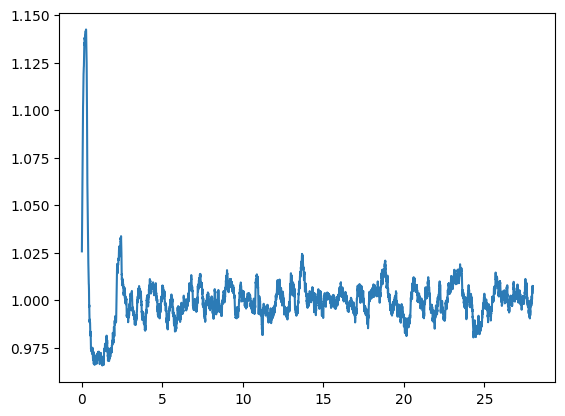

In [172]:
xax = np.array(range(stalta_data.shape[1])) * dt
plt.plot(xax, np.mean(stalta_data, axis=0), color=colors[0], linewidth=1.5)

## Low frequency synthetic test

In [90]:
n_shots = 1

n_sources_per_shot = 2
d_source = 1500  # 20 * 4m = 80m
first_source = 10  # 10 * 4m = 40m
source_depth = 500  # 2 * 4m = 8m
# first_source = int(ny/2)
# source_depth = int(2*nx/3)

n_receivers_per_shot = 384
d_receiver = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 2  # 2 * 4m = 8m

n_receivers_per_shot = min(n_receivers_per_shot, int(nx / d_receiver))

freq = 1
nt = 750 * 10
dt = 0.004
peak_time = 10 / freq

# source_locations
source_locations = torch.zeros(
    n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device
)

source_locations[..., 1, 0] = 500
source_locations[..., 1, 1] = 500

# source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = torch.arange(n_shots) * d_source + first_source

# receiver_locations
receiver_locations = torch.zeros(
    n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device
)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    torch.arange(n_receivers_per_shot) * d_receiver + first_receiver
).repeat(n_shots, 1)

# source_amplitudes
# source_amplitudes = (
#     deepwave.wavelets.ricker(freq, nt, dt, peak_time)
#     .repeat(n_shots, n_sources_per_shot, 1)
#     .to(device)
# )

source_amplitudes = (torch.cat((deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1),
                    deepwave.wavelets.ricker(freq, nt, dt, 2 + peak_time).repeat(n_shots, 1, 1)), dim=1)).to(device)

In [91]:
out_2 = scalar(
    v,
    dx,
    dt,
    source_amplitudes=source_amplitudes,
    source_locations=source_locations,
    receiver_locations=receiver_locations,
    accuracy=8,
    pml_freq=freq,
)

Text(0, 0.5, 'Amplitude')

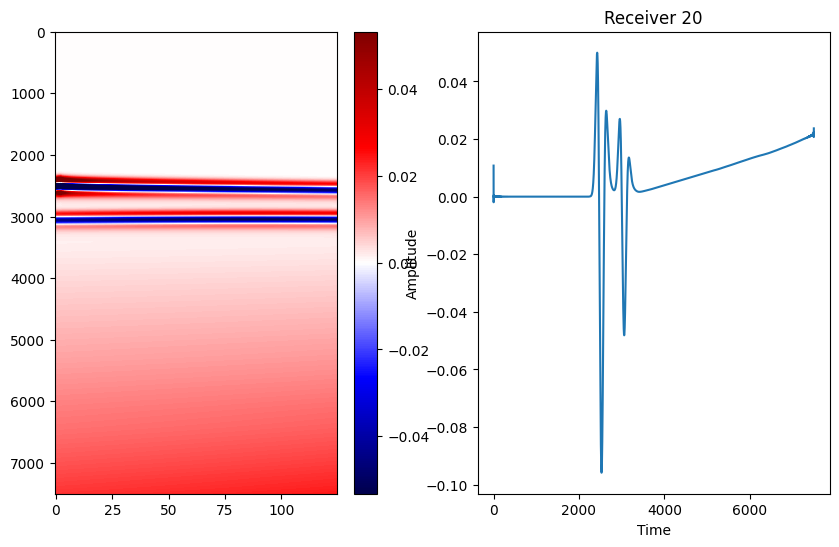

In [105]:
receiver_amplitudes_2 = out_2[-1]

vmin, vmax = torch.quantile(
    receiver_amplitudes_2[0], torch.tensor([0.1, 0.999]).to(device)
)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(
    receiver_amplitudes_2.cpu()[0].T,
    aspect="auto",
    cmap="seismic",
    vmin=-vmax,
    vmax=vmax,
)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(receiver_amplitudes_2.cpu()[0, 19])
plt.title("Receiver 20")
plt.xlabel("Time")
plt.ylabel("Amplitude")

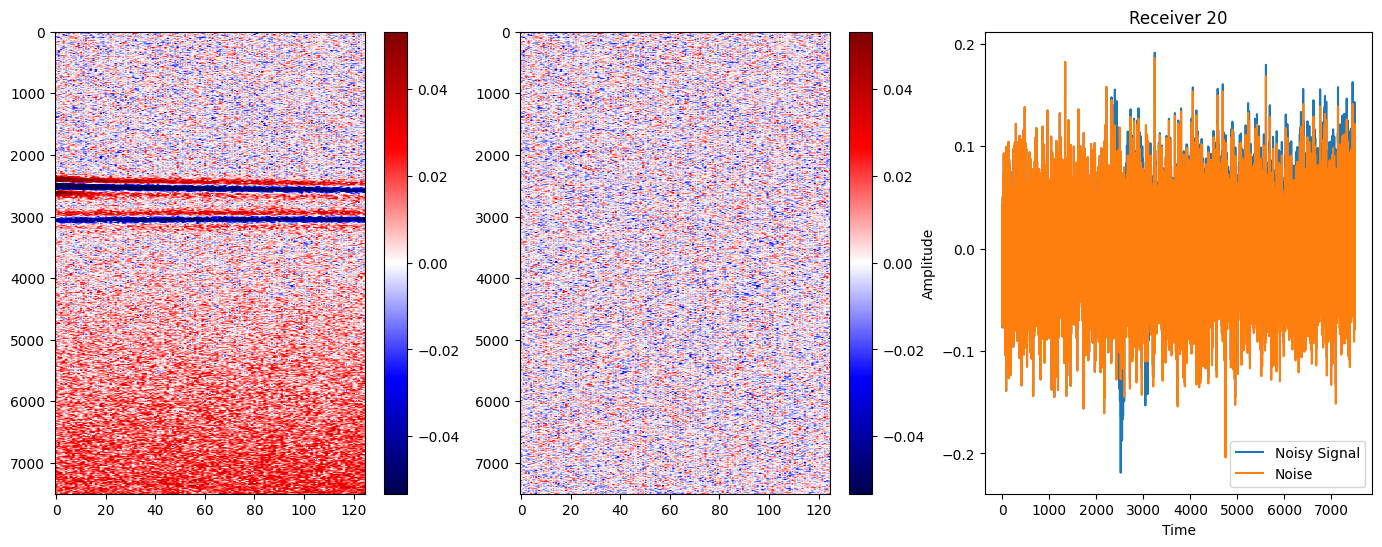

In [157]:
plt.figure(figsize=(17, 6))
coherence_data_2 = receiver_amplitudes_2[0].cpu().numpy()
nr, nc = coherence_data_2.shape
noise = np.random.normal(scale=1, size=(nr, nc))
# normalize noise
# noise = noise / np.linalg.norm(noise)
noise = noise / np.max(np.abs(noise))
noise = noise * np.max(np.abs(coherence_data_2)) * 1
coherence_data_2 = coherence_data_2 + noise
# coherence_data.shape
vmin, vmax = torch.quantile(
    receiver_amplitudes_2[0], torch.tensor([0.1, 0.999]).to(device)
)
plt.subplot(1, 3, 1)
plt.imshow(
    coherence_data_2.T, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax
)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(noise.T, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.plot(coherence_data_2[19], label='Noisy Signal')
plt.plot(noise[19], label='Noise')
plt.title("Receiver 20")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

In [158]:
win_len = 2
overlap = 0
samples_per_sec = 1 / dt

t0 = time.time()
norm_win_spectra_2, frequencies = f.normalised_windowed_spectra(
    coherence_data_2, win_len, overlap, sample_interval=1 / samples_per_sec
)
t1 = time.time()
common_time = t1 - t0

welch_coherence_mat_2 = np.matmul(
    norm_win_spectra_2, np.conjugate(norm_win_spectra_2.transpose(0, 2, 1))
)
coherence_2 = np.absolute(welch_coherence_mat_2) ** 2

norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    noise, win_len, overlap, sample_interval=1 / samples_per_sec
)
welch_coherence_mat_noise = np.matmul(
    norm_win_spectra_noise,
    np.conjugate(norm_win_spectra_noise.transpose(0, 2, 1)),
)
coherence_noise = np.absolute(welch_coherence_mat_noise) ** 2

In [159]:
num_frames = coherence_2.shape[0]

event_detection_2 = np.empty(num_frames)
event_detection_qr_2 = np.empty(num_frames)
event_detection_svd_2 = np.empty(num_frames)

noise_detection = np.empty(num_frames)
noise_detection_qr = np.empty(num_frames)
noise_detection_svd = np.empty(num_frames)

t0 = time.time()
welch_coherence_mat_2 = np.matmul(
    norm_win_spectra_2, np.conjugate(norm_win_spectra_2.transpose(0, 2, 1))
)
coherence2_2 = np.absolute(welch_coherence_mat_2) ** 2
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(coherence2[d])
    eigenvals = np.linalg.eigvalsh(coherence2_2[d])
    # eigenvals = sl.eigvalsh(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    event_detection_2[d] = np.max(eigenvals) / np.sum(eigenvals)

    eigenvals = np.linalg.eigvalsh(coherence_noise[d])
    # eigenvals = sl.eigvalsh(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    noise_detection[d] = np.max(eigenvals) / np.sum(eigenvals)
    # eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)
t1 = time.time()
eig_time = t1 - t0 + common_time

t0 = time.time()
for d in range(num_frames):
    R = np.linalg.qr(norm_win_spectra_2[d], mode='r')
    # qr_approx2 = np.sort(np.diag(np.absolute(R@(R.getH()))))[::-1]

    RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH),0.5)
    qr_approx2 = np.diag(RRH)
    event_detection_qr_2[d] = np.max(qr_approx2) / np.sum(qr_approx2)

    R = np.linalg.qr(norm_win_spectra_noise[d], mode='r')
    # qr_approx2 = np.sort(np.diag(np.absolute(R@(R.getH()))))[::-1]

    RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH),1)
    qr_approx2 = np.diag(RRH)
    noise_detection_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)
t1 = time.time()
qr_time = t1 - t0 + common_time

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(norm_win_spectra[d], full_matrices=False)
    S = np.linalg.svd(norm_win_spectra_2[d], compute_uv=False, hermitian=False)
    # S= np.linalg.svdvals(norm_win_spectra[d])
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    event_detection_svd_2[d] = np.max(svd_approx2) / np.sum(svd_approx2)

    S = np.linalg.svd(
        norm_win_spectra_noise[d], compute_uv=False, hermitian=False
    )
    # S = np.linalg.svdvals(norm_win_spectra_noise[d])
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    noise_detection_svd[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
svd_time = t1 - t0 + common_time

print("Eigenvalue time: ", eig_time)
print("QR time: ", qr_time)
print("SVD time: ", svd_time)

Eigenvalue time:  0.9475247859954834
QR time:  0.09546041488647461
SVD time:  0.09113240242004395


C:\Users\issah\AppData\Local\Temp\ipykernel_252\1026478307.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  event_detection_qr_2[d] = np.max(qr_approx2) / np.sum(qr_approx2)
C:\Users\issah\AppData\Local\Temp\ipykernel_252\1026478307.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  noise_detection_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)


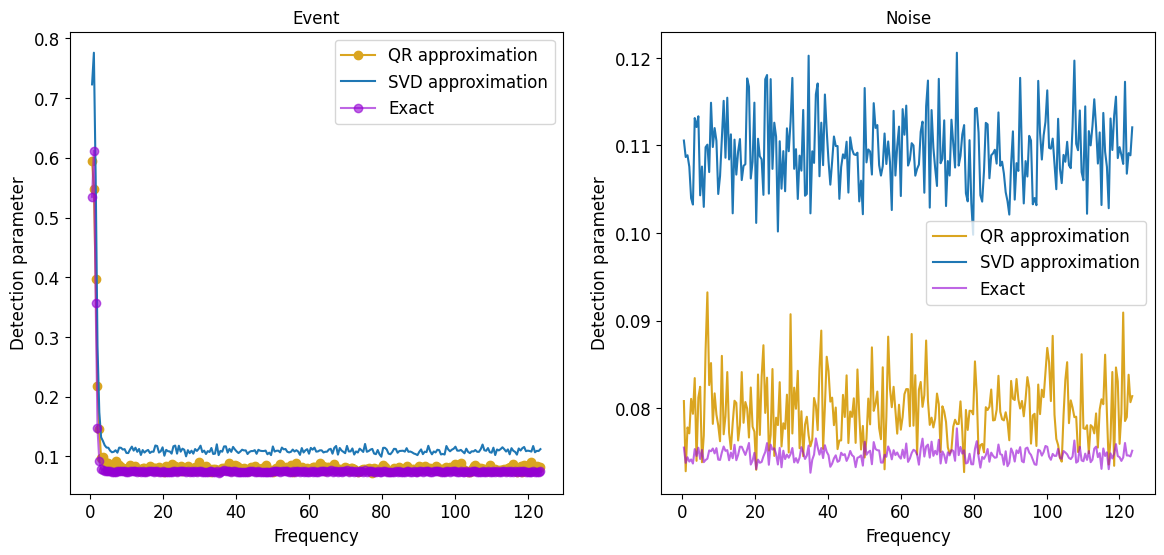

In [160]:
fsize = 12
last_freq_index = -1
f_plot = np.linspace(0, 124, num_frames)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(
    f_plot[1:last_freq_index],
    event_detection_qr_2[1:last_freq_index],
    "-o",
    color="goldenrod",
    label="QR approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    event_detection_svd_2[1:last_freq_index],
    label="SVD approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    event_detection_2[1:last_freq_index],
    "-o",
    color="darkviolet",
    alpha=0.6,
    label="Exact",
)

plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Event", fontsize=fsize)
plt.legend(fontsize=fsize)

plt.subplot(1, 2, 2)
plt.plot(
    f_plot[1:last_freq_index],
    noise_detection_qr[1:last_freq_index],
    color="goldenrod",
    label="QR approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    noise_detection_svd[1:last_freq_index],
    label="SVD approximation",
)
plt.plot(
    f_plot[1:last_freq_index],
    noise_detection[1:last_freq_index],
    color="darkviolet",
    alpha=0.6,
    label="Exact",
)

plt.ylabel("Detection parameter", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title("Noise", fontsize=fsize)
plt.legend(fontsize=fsize)